In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

In [2]:
# alpha = 0.9
# beta = 0.2
# gamma = 0.1

# Gamma = np.array([[1-gamma, 0, gamma], [0, 1-gamma, gamma], [beta/2, beta/2, 1-beta]])

# Z_given_C = np.array([1-alpha, alpha, 0.5])

In [3]:
#stats.bernoulli(0.5).rvs(size=[2,2])

array([[0, 0],
       [1, 0]], dtype=int64)

In [4]:
# xk = np.arange(3)
# C_transitition = [
#         stats.rv_discrete(values=(xk,Gamma[0,])),
#         stats.rv_discrete(values=(xk,Gamma[1,])),
#         stats.rv_discrete(values=(xk,Gamma[2,])),
#     ]

# Z_given_C[C_transitition[2].rvs(size=100)]



array([0.5, 0.1, 0.9, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.9, 0.5, 0.9, 0.5, 0.5, 0.1,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9, 0.9, 0.9, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9, 0.5])

In [8]:
def sim(n=1000, T=1000, alpha = 0.9, beta = 0.2, gamma = 0.1, lamb0=1, lamb1=5):
    xk = np.arange(3)   
    Gamma = np.array([[1-gamma, 0, gamma], 
                      [0, 1-gamma, gamma], 
                      [beta/2, beta/2, 1-beta]])
    C_transition = [
        stats.rv_discrete(values=(xk,Gamma[0,])),
        stats.rv_discrete(values=(xk,Gamma[1,])),
        stats.rv_discrete(values=(xk,Gamma[2,])),
    ]
    C = np.zeros(T, np.int64)
    C[0] = 2
    for i in range(T-1):
        C[i+1] = C_transition[C[i]].rvs()
    Z_given_C = np.array([1-alpha, alpha, 0.5]) 
    Z = stats.bernoulli(Z_given_C[C]).rvs(size=[n,T])
    X = stats.poisson(np.where(Z, lamb1, lamb0)).rvs()
    return C,Z,X


C, Z, X = sim(10, 100)

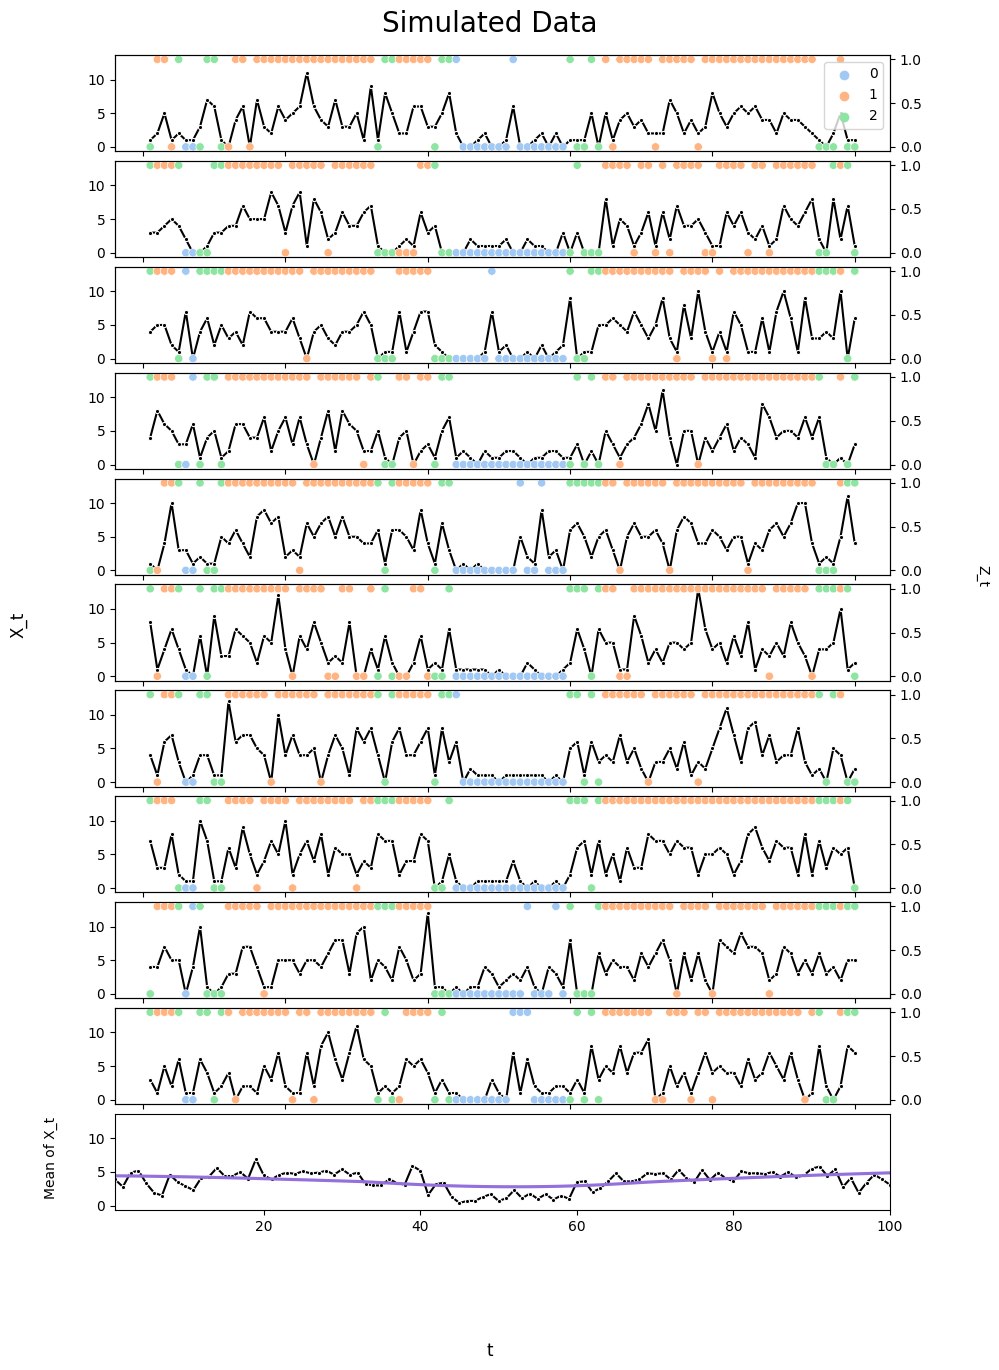

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('bright')

fig, axs = plt.subplots(11,1, sharey=True, figsize = (10,15))

x_plot = list(range(1, 100+1))

for i in range(10):
    y_plot = X[i]
    z_plot = Z[i]
    sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
    axs_ = axs[i].twinx()
    if i == 0:
        sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=C, palette = 'pastel', legend=True)#, label='Z')
        plt.legend(title = 'C_t')
        plt.legend(loc='upper right')

    else:
        sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=C, palette = 'pastel', legend=False)#, label='Z')

# Plotting the average of X over T
        
fig.suptitle('Simulated Data', fontsize=20, y = 0.91)
fig.supxlabel('t')
fig.supylabel('X_t')
plt.text(117, 5.9, 'Z_t', rotation = 270)

average_x = np.mean(X, axis=0)
sns.lineplot(x=x_plot, y=average_x, marker='o', markersize=3, color='black', ax=axs[10], legend=False)
sns.regplot(x=x_plot, y=average_x, ax=axs[10], scatter=False, color='mediumpurple', lowess=True)
plt.text(-14, -1.1, 'Mean of X_t', rotation = 90) #horrible, but it works :)


plt.subplots_adjust(hspace = 0.1)

plt.show()

# Logistic Regression

In [30]:
N = 100
n2 = 10
T = 100

#Training set
np.random.seed(42)

C, Z, X = np.empty(shape=(N,T)), np.empty(shape=(N,n2,T)), np.empty(shape=(N, n2,T))
for i in range(N):
    C[i], Z[i], X[i] = sim(n2,T)

#Test set
N_test = 100
C_test, Z_test, X_test = np.empty(shape=(N_test,T)), np.empty(shape=(N_test,n2,T)), np.empty(shape=(N_test, n2, T))
for i in range(N_test):
    C_test[i], Z_test[i], X_test[i] = sim(n2,T)

In [31]:
#Defining regression model
lr_model1 = LogisticRegression(max_iter=10000)

#Model 1 - using all X's
X_model1 = X[:,:,:].reshape((N, 100*n2))
lr_model1.fit(X_model1, C[:,49])   # [49] is C_50 because of zero-indexing
X_model1_test = X_test[:,:,:].reshape((N_test, 100*n2))

In [32]:
#model1
np.mean(lr_model1.predict(X_model1_test) == C_test[:,49])

0.67

In [33]:
lr_model2 = LogisticRegression(max_iter=10000)

#Model 2 - using only neighbouring X's
X_model2 = X[:,:,48:51].reshape((N, 3*n2))
lr_model2.fit(X_model2, C[:,49])
X_model2_test = X_test[:,:,48:51].reshape((N_test, 3*n2))


In [34]:
#model 2
np.mean(lr_model2.predict(X_model2_test) == C_test[:,49])

0.73

In [35]:
lr_model3 = LogisticRegression(max_iter=10000)

#Model 3 - using only descendant X's
X_model3 = X[:,:,49].reshape((N, n2))
lr_model3.fit(X_model3, C[:,49])
X_model3_test = X_test[:,:,49].reshape((N_test, n2))


In [36]:
#model 3
np.mean(lr_model3.predict(X_model3_test) == C_test[:,49])


0.76

In [37]:
lr_model4 = LogisticRegression(max_iter=5000)

#Model 4 - using only neighbouring X's
X_model4 = X[:,:,0:39].reshape((N, 39*n2))
lr_model4.fit(X_model4, C[:,49])
X_model4_test = X_test[:,:,0:39].reshape((N_test, 39*n2))


In [38]:
#model 4
np.mean(lr_model4.predict(X_model4_test) == C_test[:,49])

0.37

## Adjusting alpha

In [27]:
def adjust_vals(valuelist):
    
    
    model1, model2, model3, model4, values = [],[],[],[],[]
    
    
    N = 1000
    n2 = 10
    T = 100

    #Training set
    np.random.seed(42)
    
    
    for val in valuelist:
        
        # Data creation

        C, Z, X = np.empty(shape=(N,T)), np.empty(shape=(N,n2,T)), np.empty(shape=(N, n2,T))
        for i in range(N):
            C[i], Z[i], X[i] = sim(n2,T, alpha = val)

        N_test = 100
        C_test, Z_test, X_test = np.empty(shape=(N_test,T)), np.empty(shape=(N_test,n2,T)), np.empty(shape=(N_test, n2, T))
        for i in range(N_test):
            C_test[i], Z_test[i], X_test[i] = sim(n2,T, alpha = val)


            
            
            
        #Model 1 - using all X's
        lr_model1 = LogisticRegression(max_iter=10000)
        X_model1 = X[:,:,:].reshape((N, 100*n2))
        lr_model1.fit(X_model1, C[:,49])   # [49] is C_50 because of zero-indexing
        X_model1_test = X_test[:,:,:].reshape((N_test, 100*n2))

        accuracy_mod1 = np.mean(lr_model1.predict(X_model1_test) == C_test[:,49])
        model1.append(accuracy_mod1)


        #Model 2 - using only neighbouring X's
        lr_model2 = LogisticRegression(max_iter=10000)
        X_model2 = X[:,:,48:51].reshape((N, 3*n2))
        lr_model2.fit(X_model2, C[:,49])
        X_model2_test = X_test[:,:,48:51].reshape((N_test, 3*n2))

        accuracy_mod2 = np.mean(lr_model2.predict(X_model2_test) == C_test[:,49])
        model2.append(accuracy_mod2)
        

        #Model 3 - using only descendant X's  
        lr_model3 = LogisticRegression(max_iter=10000)
        X_model3 = X[:,:,49].reshape((N, n2))
        lr_model3.fit(X_model3, C[:,49])
        X_model3_test = X_test[:,:,49].reshape((N_test, n2))

        accuracy_mod3 = np.mean(lr_model3.predict(X_model3_test) == C_test[:,49])
        model3.append(accuracy_mod3)


        #Model 4 - using only neighbouring X's
        lr_model4 = LogisticRegression(max_iter=5000)
        X_model4 = X[:,:,0:39].reshape((N, 39*n2))
        lr_model4.fit(X_model4, C[:,49])
        X_model4_test = X_test[:,:,0:39].reshape((N_test, 39*n2))

        accuracy_mod4 = np.mean(lr_model4.predict(X_model4_test) == C_test[:,49])
        model4.append(accuracy_mod4)
                                       
        values.append(val)
    
                                       
    df = pd.DataFrame({
    'Model 1': model1,
    'Model 2': model2,
    'Model 3': model3,
    'Model 4': model4,
    'Value': values
    })
                                       
    
    return df

        

In [28]:
vals_list = np.arange(0.01,1,0.05)

In [29]:
alpha_df = adjust_vals(valuelist = vals_list)

In [30]:
alpha_df

,Model 1,Model 2,Model 3,Model 4,Value
0,0.79,0.98,0.94,0.40,0.01
1,0.78,0.93,0.87,0.42,0.06
2,0.80,0.88,0.75,0.35,0.11
3,0.79,0.90,0.81,0.28,0.16
4,0.65,0.81,0.62,0.23,0.21
5,0.60,0.70,0.71,0.33,0.26
6,0.58,0.71,0.62,0.34,0.31
7,0.43,0.61,0.43,0.35,0.36
8,0.51,0.61,0.49,0.34,0.41
9,0.39,0.39,0.47,0.30,0.46


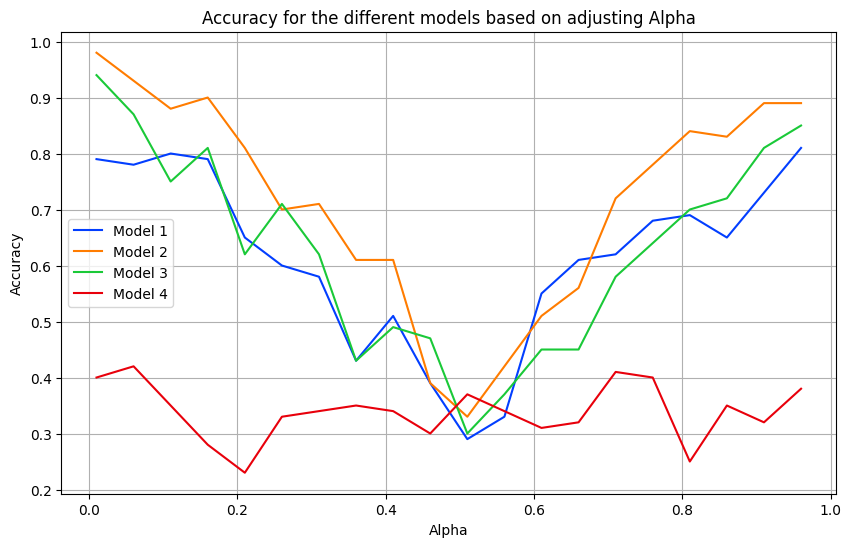

In [33]:
df = alpha_df

# Plot
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(df['Value'], df['Model 1'], label='Model 1')
plt.plot(df['Value'], df['Model 2'], label='Model 2')
plt.plot(df['Value'], df['Model 3'], label='Model 3')
plt.plot(df['Value'], df['Model 4'], label='Model 4')


plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy for the different models based on adjusting Alpha')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

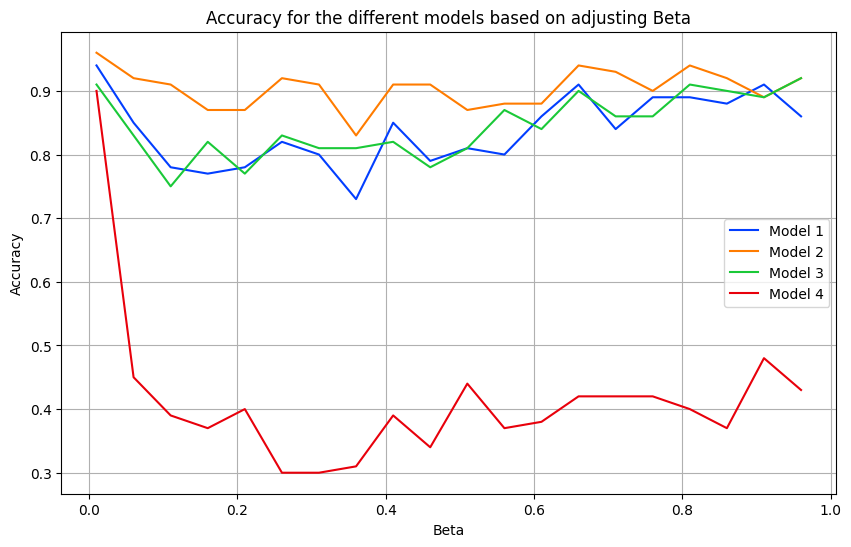

In [20]:
df = beta_df

# Plot
plt.figure(figsize=(10, 6))

# Plot lines
plt.plot(df['Value'], df['Model 1'], label='Model 1')
plt.plot(df['Value'], df['Model 2'], label='Model 2')
plt.plot(df['Value'], df['Model 3'], label='Model 3')
plt.plot(df['Value'], df['Model 4'], label='Model 4')


plt.xlabel('Beta')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.title('Accuracy for the different models based on adjusting Beta')



# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

# TRASH

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set_palette('bright')

# fig, axs = plt.subplots(10,1, sharey=True, figsize = (10,15))

# x_plot = list(range(1, 100+1))

# for i in range(10):
#     y_plot = X[i]
#     z_plot = Z[i]
#     sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
#     axs_ = axs[i].twinx()
#     if i == 0:
#         sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=C, palette = 'pastel', legend=True)#, label='Z')
#         plt.legend(title = 'C_t')
#     else:
#         sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs_, hue=C, palette = 'pastel', legend=False)#, label='Z')


# fig.suptitle('Generated Data', fontsize=20, y = 0.91)
# fig.supxlabel('t')
# fig.supylabel('X_t')

# plt.text(117, 5.9, 'Z_t', rotation = 270)

# plt.subplots_adjust(hspace = 0.1)

# #plt.tight_layout()
# plt.show()

In [ ]:
# fig, axs = plt.subplots(10, 1, figsize= (6.5, 8))
# x_plot = list(range(1,100+1))
# col = ("red", "green", "blue")
# color_list = [col[i] for i in C]

# for i in range(10):
#     y_plot = X[i]
#     z_plot = Z[i]*10
#     axs[i].plot(x_plot, y_plot, marker='o', markersize=3, color='black')
#     axs[i].plot(x_plot, z_plot, c=color_list)

# fig.suptitle('Generated Data', fontsize=16)
# fig.supxlabel('t')
# fig.supylabel('X_t')

# plt.tight_layout()
# plt.legend()
# plt.show()

In [ ]:
# OLD CODE

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('bright')


fig, axs = plt.subplots(10, 1, figsize=(10, 15))
x_plot = list(range(1, 100+1))
col = ["red", "green", "blue"]
color_list = [col[i] for i in C]

for i in range(10):
    y_plot = X[i]
    z_plot = Z[i]* 10
    sns.lineplot(x=x_plot, y=y_plot, marker='o', markersize=3, color='black', ax=axs[i], legend=False)#, label='X')
    sns.scatterplot(x=x_plot, y=z_plot, marker='o', ax=axs[i], hue=color_list, legend=False)#, label='Z')


fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.subplots_adjust(hspace = 0.1)

#plt.tight_layout()
plt.show()


In [2]:
# Parameters
alfa = 0.9
beta = 0.2
gamma = 0.1
lambda0 = 1
lambda1 = 5

In [3]:
def forward_simulation(N=10, T=100):
    
    c_states = [0,1,2]
    
    # T1 C is 1
    
    c_list = [2]
    
    # Generate C's
    
    for c in range(T-1):
        
        previous_c = c_list[-1]
            
        if previous_c == 2:

            c = random.choices(c_states, weights=(beta/2,beta/2,1-beta), k=1)

        elif previous_c == 1:

            c = random.choices(c_states, weights=(0,1-gamma,gamma), k=1)

        elif previous_c == 0:

            c = random.choices(c_states, weights=(1-gamma,0,gamma), k=1)
            

        c_list.append(c[0])                

    # Generate Z
    
    Zdf = pd.DataFrame()
    
    z_states = [0,1]
    
    
    for number, c_ in enumerate(c_list):
                
        if c_ == 0:
            
            z = random.choices(z_states, weights=(alfa, 1-alfa), k=N)
                        
        elif c_ == 1:
            
            z = random.choices(z_states, weights=(1-alfa, alfa), k=N)
                        
            
        elif c_ == 2:

            z = random.choices(z_states, weights=(0.5, 0.5), k=N)
        
        columnname = 't'+ str(number)
        Zdf[columnname] = z
    
    Znp = Zdf.to_numpy()
    
    
    Znp = Znp.T.copy() # row is T, Column is N
    
    
    # Generate X

    X = []
    
    for row in Znp:
        
        xs = []
        
        for obs in row:
                        
            if obs == 1:
                
                x = np.random.poisson(lam = lambda1, size = 1)

            elif obs == 0:

                x = np.random.poisson(lam = lambda0, size = 1)

            xs.append(x[0])
            
        X.append(xs)
        
        Xnp = np.array(X)
        
                    
    
    return np.array(c_list), Znp, Xnp
    
    
    
    
    
    
    

In [4]:
C, Z, X = forward_simulation()



### Visualization

In [5]:
res = np.array([sum(idx) for idx in zip(*X.T)])
res = res/10

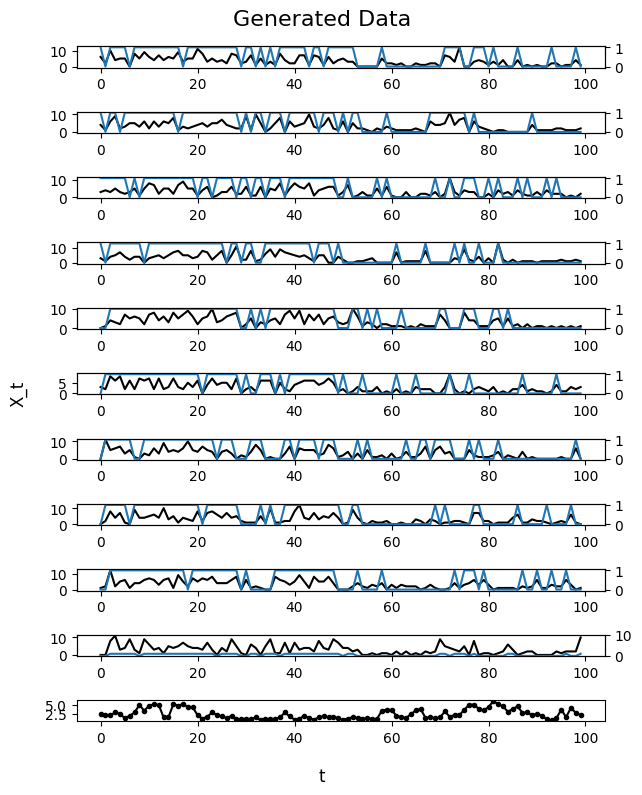

In [34]:
fig, axs = plt.subplots(11, 1, figsize= (6.5, 8))
x_plot = list(range(0,100))

for i in range(10):
    y_plot = X.T[i]
    z_plot = Z.T[i]
    axs[i].plot(x_plot, y_plot, markersize=3, color='black')
    axs[i] = axs[i].twinx()
    axs[i].plot(x_plot, z_plot)


axs[10].plot(x_plot, res, marker='o', markersize=3, color='black') # Adding a mean

plt.ylim((0,10))


fig.suptitle('Generated Data', fontsize=16)
fig.supxlabel('t')
fig.supylabel('X_t')

plt.tight_layout()
plt.show()

### logistic regression

In [7]:
C, Z, X = forward_simulation(10, 100)

In [8]:
X.shape

(100, 10)

In [11]:
len(X.T)

10

In [12]:
from scipy import stats

slopes = []
for t in X.T:
    slope, intercept, r, p, std_err = stats.linregress(C,t)
    slopes.append(slope)